# Python版RNA-seq分析教程：差异表达基因分析

Bulk RNA-seq 分析的一个重要任务是分析差异表达基因，我们可以用 omicverse包 来完成这个任务。对于差异表达分析而言，首先，我们可以先将 gene_id 改为 gene_name。其次，当我们的数据集存在批量效应时，我们可以使用 DEseq2的 SizeFactor 对其进行归一化，并使用 wilcoxon 的 t 检验来计算基因的 p 值。在这里，我们用一个从RNA-seq上游的定量包FeatureCounts生成的表达矩阵来演示差异表达分析的流程。我们的流程适用于任何Bulk RNA-seq的差异表达分析。

## 环境的下载
在这里我们只需要安装omicverse环境即可，有两个方法：

- 一个是使用conda：conda install omicverse -c conda-forge
- 另一个是使用pip：pip install omicverse -i https://pypi.tuna.tsinghua.edu.cn/simple/。-i的意思是指定清华镜像源，在国内可能会下载地快一些。

`pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.1.1+cu121.html --no-index`


## 导入包
我们首先导入分析需要用到的所有包，包括omicverse, pandas, numpy, scanpy matplotlib 和 seaborn.

In [1]:
import omicverse as ov
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns

# 设定绘图格式，分辨率300dpi等
ov.utils.ov_plot_set()

/slurm/home/admin/.conda/envs/grns/lib/python3.11/site-packages/torch_geometric/typing.py:54: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: /lib64/libm.so.6: version `GLIBC_2.29' not found (required by /slurm/home/admin/.conda/envs/grns/lib/python3.11/site-packages/libpyg.so)
  warnings.warn(f"An issue occurred while importing 'pyg-lib'. "
/slurm/home/admin/.conda/envs/grns/lib/python3.11/site-packages/torch_geometric/typing.py:110: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /lib64/libm.so.6: version `GLIBC_2.29' not found (required by /slurm/home/admin/.conda/envs/grns/lib/python3.11/site-packages/libpyg.so)
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "



   ____            _     _    __                  
  / __ \____ ___  (_)___| |  / /__  _____________ 
 / / / / __ `__ \/ / ___/ | / / _ \/ ___/ ___/ _ \ 
/ /_/ / / / / / / / /__ | |/ /  __/ /  (__  )  __/ 
\____/_/ /_/ /_/_/\___/ |___/\___/_/  /____/\___/                                              

Version: 1.6.5, Tutorials: https://omicverse.readthedocs.io/
All dependencies are satisfied.


## 下载基因集
当我们需要转换基因 id 时，我们需要准备一个映射对文件。在这里，我们预处理了6个基因组 gtf 文件和生成的映射对，包括 T2T-CHM13，GRCh38，GRCh37，GRCm39，danRer7和 danRer11。如果需要转换其他 id，可以使用 gtf 将文件放在 genesets 目录中生成自己的映射。

In [4]:
ov.utils.download_geneid_annotation_pair()

......Geneid Annotation Pair download start: pair_GRCm39
......Downloading dataset save to genesets/pair_GRCm39.tsv
......Creating directory genesets
......[pair_GRCm39 Size of file]: 0.14 MB
......[Downloader]: >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>100.00%
.......Finish！63.47662377357483.2f s
......Geneid Annotation Pair download start: pair_T2TCHM13
......Downloading dataset save to genesets/pair_T2TCHM13.tsv
......[pair_T2TCHM13 Size of file]: 0.15 MB
......[Downloader]: >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>100.00%
.......Finish！41.00421619415283.2f s
......Geneid Annotation Pair download start: pair_GRCh38
......Downloading dataset save to genesets/pair_GRCh38.tsv
......[pair_GRCh38 Size of file]: 0.13 MB
......[Downloader]: >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>100.00%
.......Finish！3.064177989959717.2f s
......Geneid Annotation Pair download start: pair_GRCh37
......Downloading dataset save to genesets/pair_GRCh37.tsv
......[pair_GRCh37 Size o

## 读取数据


In [2]:
data=pd.read_csv('./data/counts.txt',
                 index_col=0,
                 sep='\t',
                 header=1)

data

,/public5/xiongyy/mouse_EV/00.CleanData/1--1/1--1.bam,/public5/xiongyy/mouse_EV/00.CleanData/1--2/1--2.bam,/public5/xiongyy/mouse_EV/00.CleanData/2--1/2--1.bam,/public5/xiongyy/mouse_EV/00.CleanData/2--2/2--2.bam,/public5/xiongyy/mouse_EV/00.CleanData/3--1/3--1.bam,/public5/xiongyy/mouse_EV/00.CleanData/3--2/3--2.bam,/public5/xiongyy/mouse_EV/00.CleanData/4--1/4--1.bam,/public5/xiongyy/mouse_EV/00.CleanData/4--2/4--2.bam,/public5/xiongyy/mouse_EV/00.CleanData/4-3/4-3.bam,/public5/xiongyy/mouse_EV/00.CleanData/4-4/4-4.bam,/public5/xiongyy/mouse_EV/00.CleanData/Blank-1/Blank-1.bam,/public5/xiongyy/mouse_EV/00.CleanData/Blank-2/Blank-2.bam
Geneid,,,,,,,,,,,,
ENSMUSG00000102628,0,0,0,0,5,0,0,0,0,0,0,9
ENSMUSG00000100595,0,0,0,0,0,0,0,0,0,0,0,0
ENSMUSG00000097426,5,0,0,0,0,0,0,1,0,0,0,0
ENSMUSG00000104478,0,0,0,0,0,0,0,0,0,0,0,0
ENSMUSG00000104385,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
ENSMUSG00002074970,0,0,0,0,0,0,0,0,0,0,0,0
ENSMUSG00002075729,0,0,0,0,0,0,0,0,0,0,0,0
ENSMUSG00002074899,0,0,0,0,0,0,0,0,0,0,0,0


In [3]:
data.columns

Index(['/public5/xiongyy/mouse_EV/00.CleanData/1--1/1--1.bam',
       '/public5/xiongyy/mouse_EV/00.CleanData/1--2/1--2.bam',
       '/public5/xiongyy/mouse_EV/00.CleanData/2--1/2--1.bam',
       '/public5/xiongyy/mouse_EV/00.CleanData/2--2/2--2.bam',
       '/public5/xiongyy/mouse_EV/00.CleanData/3--1/3--1.bam',
       '/public5/xiongyy/mouse_EV/00.CleanData/3--2/3--2.bam',
       '/public5/xiongyy/mouse_EV/00.CleanData/4--1/4--1.bam',
       '/public5/xiongyy/mouse_EV/00.CleanData/4--2/4--2.bam',
       '/public5/xiongyy/mouse_EV/00.CleanData/4-3/4-3.bam',
       '/public5/xiongyy/mouse_EV/00.CleanData/4-4/4-4.bam',
       '/public5/xiongyy/mouse_EV/00.CleanData/Blank-1/Blank-1.bam',
       '/public5/xiongyy/mouse_EV/00.CleanData/Blank-2/Blank-2.bam'],
      dtype='object')

In [4]:
data.columns=[i.split('/')[-1].replace('.bam','') for i in data.columns]
data.head()

,1--1,1--2,2--1,2--2,3--1,3--2,4--1,4--2,4-3,4-4,Blank-1,Blank-2
Geneid,,,,,,,,,,,,
ENSMUSG00000102628,0,0,0,0,5,0,0,0,0,0,0,9
ENSMUSG00000100595,0,0,0,0,0,0,0,0,0,0,0,0
ENSMUSG00000097426,5,0,0,0,0,0,0,1,0,0,0,0
ENSMUSG00000104478,0,0,0,0,0,0,0,0,0,0,0,0
ENSMUSG00000104385,0,0,0,0,0,0,0,0,0,0,0,0


值得注意的是，我们的数据集并没有经过任何处理，featurecounts比对时用的gtf为GRCm39，所以我们这里用GRCm39来做基因id映射



## 基因id转换


In [5]:
data=ov.bulk.Matrix_ID_mapping(data,'genesets/pair_GRCm39.tsv')
data.head()

,1--1,1--2,2--1,2--2,3--1,3--2,4--1,4--2,4-3,4-4,Blank-1,Blank-2
Atg4b,1277,1001,743,811,1134,1608,1356,1005,613,858,452,802
Gm10447,0,0,0,0,0,0,0,0,0,0,7,0
7SK,0,0,0,0,0,0,2,0,0,0,0,0
1700008P02Rik,0,0,0,0,0,0,0,0,0,0,0,0
Gm47223,0,0,0,0,0,0,0,0,0,0,0,0


## 差异表达分析
我们可以非常简单地通过omicverse进行差异表达基因分析，只需要提供一个表达式矩阵。我们首先创建一个 `pyDEG` 对象，并使用`drop_duplicates_index`去除重复的基因。由于部分基因名相同，我们的去除保留了表达量最大的基因名。

In [6]:
dds=ov.bulk.pyDEG(data)
dds

In [7]:
dds.drop_duplicates_index()
print('... drop_duplicates_index success')

... drop_duplicates_index success


我们还需要去除表达矩阵的批次效应 `(batch effect)`，我们使用`DEseq2`的的 `SizeFactor` 来对我们的矩阵计算归一化因子来去除批次效应。

In [8]:
dds.normalize()
print('... estimateSizeFactors and normalize success')

... estimateSizeFactors and normalize success


现在我们可以从表达矩阵中计算差异表达基因，在计算前我们需要输入实验组和对照组。在这里，我们指定 4-3和4-4为实验组，1--1, 1--2为对照组，使用ttest进行差异表达分析计算。当然你也可以使用wilcox来计算。此外deseq2也是支持的，不过流程可能会有一些区别，我们放到下一期讲。

In [9]:
dds.data

,1--1,1--2,2--1,2--2,3--1,3--2,4--1,4--2,4-3,4-4,Blank-1,Blank-2
Col1a1,272732.854408,370542.804199,228142.053055,489308.279897,346726.474201,390001.963773,241409.788589,44200.080816,512507.931156,510006.013981,14056.989711,30314.845917
Col3a1,278199.560084,403106.069226,320358.971822,562018.195153,280374.434541,388262.200103,199520.143732,37696.087730,448870.171723,438660.970601,23212.249899,41466.108350
Col1a2,241916.348248,391367.070799,263165.816533,444376.959951,261354.469369,302367.025068,193489.048403,38546.382591,417585.067703,406954.956434,23269.314810,44606.872579
Sparc,92788.750572,134541.382318,103760.923830,171690.553805,95245.338496,115968.121311,77420.171940,21224.007923,137297.814245,134173.039920,11841.700607,23109.134368
Eef1a1,104502.980620,89004.429973,121769.823117,100751.979900,91955.375304,87312.731352,92352.067947,111881.454566,79298.153528,88520.386599,75363.725623,57356.771245
...,...,...,...,...,...,...,...,...,...,...,...,...
Mir412,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Gm43156,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Gm28256,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Gm4064,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [15]:
treatment_groups = ['4-3','4-4'] # 治疗
control_groups = ['1--1','1--2'] # 正常
result=dds.deg_analysis(treatment_groups, # 第一组进行比较
                        control_groups,  # 第二组进行比较
                        method='ttest')
result

,pvalue,qvalue,FoldChange,MaxBaseMean,BaseMean,log2(BaseMean),log2FC,abs(log2FC),size,-log(pvalue),-log(qvalue),sig
Col1a1,0.060577,0.106795,1.589542,511256.972569,416447.400936,18.667775,0.668611,0.668611,0.158954,1.217694,0.971449,normal
Col3a1,0.241596,0.360371,1.302691,443765.571162,392209.192909,18.581264,0.381495,0.381495,0.130269,0.616910,0.443250,normal
Col1a2,0.329959,0.464645,1.302008,412270.012069,364455.860796,18.475385,0.380738,0.380738,0.130201,0.481540,0.332878,normal
Sparc,0.402329,0.516157,1.194170,135735.427082,124700.246764,16.928105,0.256008,0.256008,0.119417,0.395419,0.287218,normal
Eef1a1,0.290359,0.419214,0.867246,96753.705297,90331.487680,16.462941,-0.205486,0.205486,0.086725,0.537064,0.377564,normal
...,...,...,...,...,...,...,...,...,...,...,...,...
Gm24753,0.422650,0.516157,3.096953,0.495613,0.247807,-2.012713,1.630850,1.630850,0.309695,0.374019,0.287218,normal
Gm17850,0.422650,0.516157,0.326561,0.487402,0.243701,-2.036815,-1.614574,1.614574,0.032656,0.374019,0.287218,normal
Gm20564,0.422650,0.516157,0.333333,0.472699,0.236349,-2.081007,-1.584963,1.584963,0.033333,0.374019,0.287218,normal
Gm11279,0.422650,0.516157,0.326561,0.487402,0.243701,-2.036815,-1.614574,1.614574,0.032656,0.374019,0.287218,normal


在计算完差异表达基因后，我们会发现一个重要的事情，就是低表达基因有很多，如果我们不对其进行过滤，会影响后续火山图的绘制，我们设定基因的平均表达量大于1作为阈值，将平均表达量低于1的基因全部过滤掉。

In [16]:
print(result.shape)
result=result.loc[result['log2(BaseMean)']>1]
print(result.shape)

(26632, 12)
(21273, 12)


我们还需要设置 `Foldchange` 的阈值，我们准备了一个名为 `foldchange_set` 的方法函数来完成。此函数根据 log2FC 分布自动计算适当的阈值，但您也可以手动输入阈值。该函数有三个参数：
- fc_threshold: 差异表达倍数的阈值，-1为自动计算
- pval_threshold: 差异表达基因的p-value过滤值，默认为0.05，在有些情况下可以设定为0.1，意味着统计学差异不显著。
- logp_max: p值的最大值，由于部分p值过小，甚至为0，取对数后火山图绘制较为困难，我们可以设定一个上限，高于这个上限的p值全部统一。

In [17]:
# -1 means automatically calculates
dds.foldchange_set(fc_threshold=-1,
                   pval_threshold=0.05,
                   logp_max=6)

... Fold change threshold: 1.5699292568224994


## 差异表达的结果可视化

`omicverse`除了有较为完善的分析能力外，还有极强的可视化能力。首先是火山图，我们使用 `plot_volcano`函数来实现。该函数可以绘制你感兴趣的基因或高表达的基因。您需要输入一些参数:

- `title`: 火山图的标题
- `figsize`: 图像大小
- `plot_genes`: 需要绘制的基因，格式为list。如['Gm8925','Snorc']
- `plot_genes_num`: 需要绘制的基因数，该参数与`plot_genes`互斥，如果我们没有指定需要绘制的基因，可以自动绘制前n个高差异表达倍数的基因。

此外，我们还可以指定绘制的颜色等，具体的参数可以使用`help(dds.plot_volcano)`来查看

<AxesSubplot: title={'center': 'DEG Analysis'}, xlabel='$log_{2}FC$', ylabel='$-log_{10}(qvalue)$'>

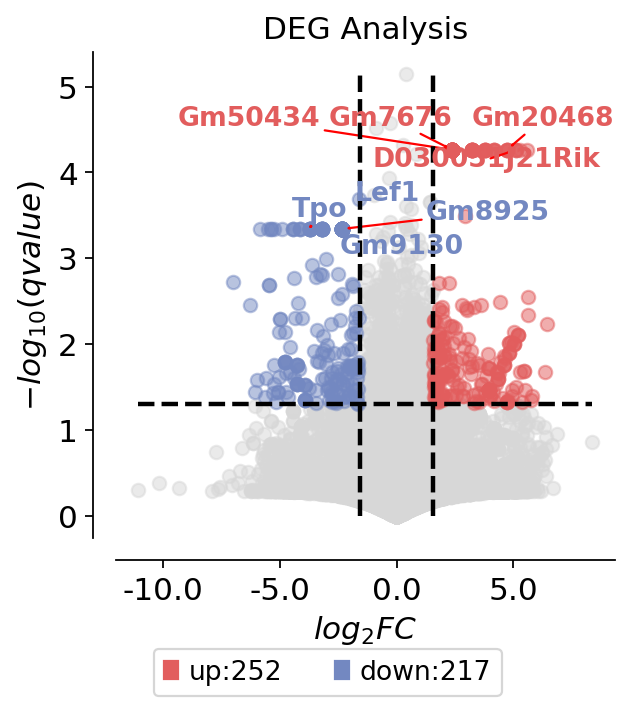

In [18]:
dds.plot_volcano(title='DEG Analysis',figsize=(4,4),
                 plot_genes_num=8,plot_genes_fontsize=12,)

如果我们想绘制特定的基因的箱线图，我们也可以使用 plot_boxplot 函数来完成该任务。

(<Figure size 160x240 with 1 Axes>,
 <AxesSubplot: title={'center': 'Gene Expression'}>)

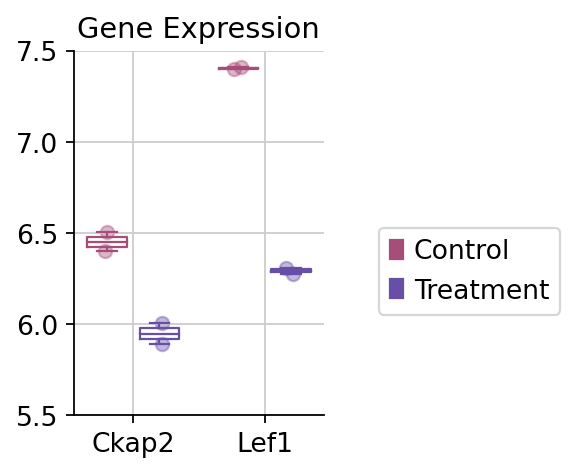

In [19]:
dds.plot_boxplot(genes=['Ckap2','Lef1'],treatment_groups=treatment_groups,
                control_groups=control_groups,figsize=(2,3),fontsize=12,
                 legend_bbox=(2,0.55))

## 通路富集分析
在差异表达基因计算出来后，我们需要直接进行的下一步分析往往是看差异表达的基因与哪些通路相关，这里我们常用的方法是富集分析。`omicverse`可以一键完成富集分析并且可视化。

我们封装了`gseapy` 包进入`omicverse`，其中包括 `GSEA` 富集分析的相关功能。我们优化了包的输出，并给出了一些更好看的图形绘制功能

类似地，我们首先需要下载通路数据库。我们已经准备好了五个基因集，可以使用 `ov.utils.download_pathway_database()`进行自动下载。除此之外，你还可以在以下网站找到你感兴趣的基因集：https://link.zhihu.com/?target=https%3A//maayanlab.cloud/enrichr/%23libraries






In [20]:
ov.utils.download_pathway_database()
#读取通路基因集，我们读取Wiki通路数据库
pathway_dict=ov.utils.geneset_prepare('genesets/WikiPathways_2019_Mouse.txt', organism='Mouse')

......Pathway Geneset download start: GO_Biological_Process_2021
......Downloading dataset save to genesets/GO_Biological_Process_2021.txt
......[GO_Biological_Process_2021 Size of file]: 0.15 MB
......[Downloader]: >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>100.00%
.......Finish！2.6129608154296875.2f s
......Pathway Geneset download start: GO_Cellular_Component_2021
......Downloading dataset save to genesets/GO_Cellular_Component_2021.txt
......[GO_Cellular_Component_2021 Size of file]: 0.03 MB
......[Downloader]: >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>100.00%
.......Finish！7.185948133468628.2f s
......Pathway Geneset download start: GO_Molecular_Function_2021
......Downloading dataset save to genesets/GO_Molecular_Function_2021.txt
......[GO_Molecular_Function_2021 Size of file]: 0.03 MB
......[Downloader]: >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>100.00%
.......Finish！21.358795881271362.2f s
......Pathway Geneset download start: WikiPathway_2021_Human
....

我们提取前面的差异表达基因来进行通路富集

In [22]:
#差异表达基因提取
deg_genes=dds.result.loc[dds.result['sig']!='normal'].index.tolist()
deg_genes

['Dct',
 'Tyrp1',
 'Pmel',
 'Cpe',
 'Mt1',
 'Cyp2e1',
 'Trpm1',
 'Igfbp2',
 'Mmp11',
 'Slc7a5',
 'Serpina3j',
 'Tyr',
 'Serpina3b',
 'Cyp26b1',
 'Hmgcs2',
 'Fads2',
 'Lef1',
 'Pi15',
 'Ptgds',
 'Ccl21a',
 'Masp1',
 'Mcpt4',
 'Pla2r1',
 'Aldh1a3',
 'Mlana',
 'Oca2',
 'Ptch2',
 'Slc45a2',
 'Cma1',
 'Rab38',
 'Dkk2',
 'Cbs',
 'Gm9844',
 'Slc24a5',
 'Arl2bp',
 'Mc1r',
 'Esco2',
 'Slc26a7',
 'Mlph',
 'Nnat',
 'Mup22',
 'Cfap54',
 'Fmo2',
 'Shh',
 'Slc24a4',
 'Cldn8',
 'Dlx4',
 'Pik3r5',
 'Mcoln3',
 'Avpr1a',
 'Gzmc',
 'Gm9115',
 'Cps1',
 'Slc22a4',
 'Slco4a1',
 'Ackr1',
 'Spink12',
 'Fanca',
 'Gm34396',
 'Adrb3',
 'Slc12a1',
 'Kcnc1',
 'Edn3',
 'Stfa2',
 'Tspan10',
 'Adam33',
 'Gpr143',
 'B3galt5',
 'Kif1a',
 'Iglon5',
 'Rspo3',
 'Tacr1',
 'Slc1a1',
 '1700019D03Rik',
 'Rad54l',
 'Spaca6',
 'Dlk1',
 'Ahrr',
 'H60c',
 'Trgc1',
 'Acvr1c',
 'Gmfg-ps',
 'Tmem150c',
 'Slc35f2',
 '1110057P08Rik',
 'Cyp2g1',
 'Slc17a9',
 'Gstp3',
 'Ncmap',
 'Ikzf3',
 'Gadl1',
 'Gm9845',
 'Cldn19',
 '4933416I08Rik',

In [26]:
dds.result.loc[dds.result['sig']!='normal']

,pvalue,qvalue,FoldChange,MaxBaseMean,BaseMean,log2(BaseMean),log2FC,abs(log2FC),size,-log(pvalue),-log(qvalue),sig
Dct,0.005357,0.010300,0.126367,14209.958982,8002.708541,12.966273,-2.984313,2.984313,0.012637,2.271067,1.987146,down
Tyrp1,0.006576,0.012618,0.111237,10973.623770,6097.040616,12.573893,-3.168298,3.168298,0.011124,2.182060,1.899011,down
Pmel,0.000525,0.001020,0.125069,7015.179820,3946.178338,11.946240,-2.999200,2.999200,0.012507,3.279877,2.991443,down
Cpe,0.007402,0.014180,3.667141,9242.702004,5881.470606,12.521961,1.874656,1.874656,0.366714,2.130679,1.848333,up
Mt1,0.021843,0.040732,0.307714,6620.291813,4328.641030,12.079698,-1.700340,1.700340,0.030771,1.660690,1.390060,down
...,...,...,...,...,...,...,...,...,...,...,...,...
Gm4883,0.000234,0.000456,0.197542,0.960101,0.480051,-1.058742,-2.339768,2.339768,0.019754,3.629929,3.341310,down
Gm8317,0.000234,0.000456,0.197542,0.960101,0.480051,-1.058742,-2.339768,2.339768,0.019754,3.629929,3.341310,down
Gm50434,0.000028,0.000055,5.216210,0.996498,0.498249,-1.005061,2.383002,2.383002,0.521621,4.553113,4.263066,up
Gm8812,0.000234,0.000456,0.197542,0.960101,0.480051,-1.058742,-2.339768,2.339768,0.019754,3.629929,3.341310,down


In [28]:
# pathway_dict # {"path_way":[gene...]}

In [29]:
#通路富集分析
enr=ov.bulk.geneset_enrichment(gene_list=deg_genes,
                               pathways_dict=pathway_dict,
                               pvalue_type='auto',
                               organism='mouse')

我们可以使用geneset_plot来可视化通路富集的结果

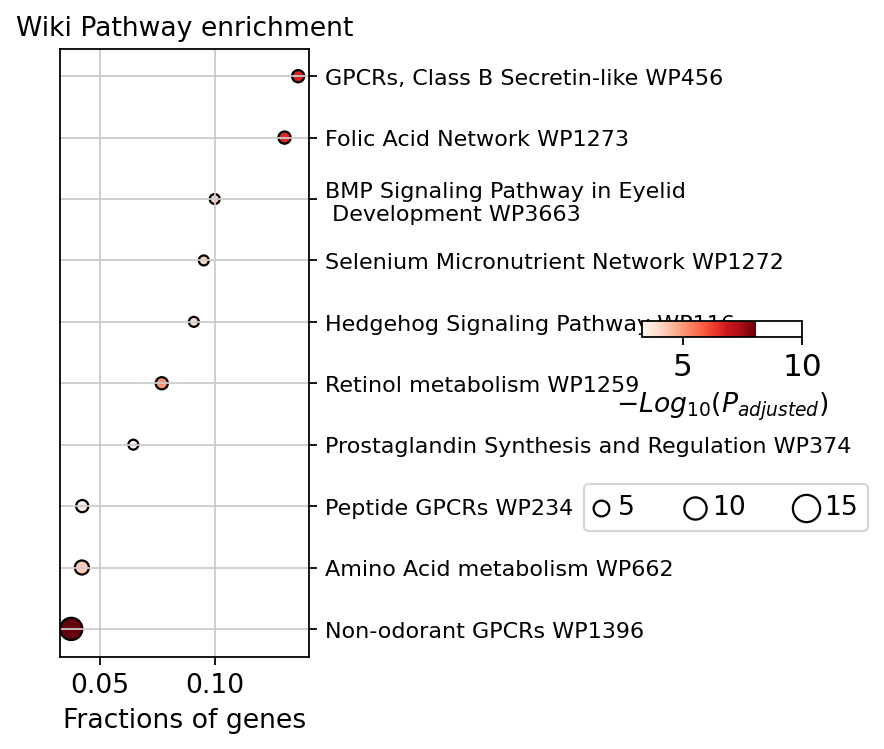

In [30]:
ov.bulk.geneset_plot(enr,figsize=(2,5),fig_title='Wiki Pathway enrichment', cmap='Reds')
#如果需要保存的话,使用`plt.savefig`来保存图像
plt.savefig("enr_pathway.png",dpi=300,bbox_inches = 'tight')